# Error Analysis

In [1]:
!pip install pandas --quiet
!pip install numpy --quiet
!pip install datasets --quiet
!pip install transformers --quiet
!pip install pytorch-lightning --quiet
!pip install scikit_learn --quiet
!pip install matplotlib --quiet

## Imports

In [2]:
import pandas as pd
import numpy as np
import sys
import torch
from datasets import load_dataset
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

sys.path.append('..')
from model import DataModule, Model


# set some pandas options to make the output more readable
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 5000)
pd.set_option('display.max_colwidth', None)

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load final Model

In [3]:
checkpoint_path = "../checkpoints/bert-base-multilingual-cased-batch16.ckpt"
model = Model.load_from_checkpoint(checkpoint_path)
data_module = DataModule(model.hparams.model_name)
tokenizer = data_module.tokenizer

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
print(device)

cuda


## Load Test Data

In [5]:
df_test = pd.read_csv('../data/oasst1_test_cleaned.csv')

In [6]:
df_test['humor_label'] = df_test.humor.apply(lambda x: 1 if x > 0.3 else 0)

In [7]:
df_test.head()

,message_id,text,role,lang,review_count,humor,humor_label
0,68489e5c-978f-4ad7-a849-39a741fb5ae7,"Напиши функцию на языке swift, которая сортирует массив целых чисел, а затем выводит его на экран",prompter,ru,3,0.00,0
1,a38b3d1c-256f-47c5-ab68-c9ab766bad84,"Вот функция, которая сортирует массив целых чисел и выводит его на экран:\n\n```swift\nfunc sortAndPrintArray(_ array: [Int]) {\n // Создаем копию массива, чтобы не изменять исходный\n var sortedArray = array\n // Сортируем массив по возрастанию\n sortedArray.sort()\n // Выводим отсортированный массив на экран\n print(sortedArray)\n}\n```\n\n\nТы можешь проверить работу функции, вызвав ее с любым массивом целых чисел, например:\n\n```swift\nsortAndPrintArray([5, 2, 7, 9, -3])\n```\n\nНа экране появится:\n\n```sh\n[-3, 2, 5, 7, 9]\n```\n---\nНадеюсь, что я смог тебе помочь. Нужно ли тебе что-нибудь ещё? 😊",assistant,ru,3,0.00,0
2,9cf52b01-0582-46aa-9ad2-70827dce87ed,"Вот функция на языке Swift, которая сортирует массив целых чисел, а затем выводит его на экран:\n\nswift\nfunc sortAndPrintArray(arr: [Int]) {\n let sortedArray = arr.sorted()\n for number in sortedArray {\n print(number)\n }\n}\nВы можете вызвать функцию, передав в качестве аргумента массив целых чисел:\n\nswift\nlet array = [3, 5, 1, 4, 2]\nsortAndPrintArray(arr: array)\n\nЭто выведет отсортированный массив на экран:\n\n1\n2\n3\n4\n5",assistant,ru,3,0.00,0
3,9685d79e-16d7-4f1b-b68f-a1ff73e87bef,func sortAndPrintArray(array: [Int]) {\n let sortedArray = array.sorted()\n print(sortedArray)\n},assistant,ru,3,0.00,0
4,afee0474-c84a-4ae2-a9c9-8d575256312e,"Inventa un monstruo altamente complejo, descríbelo y enumera sus ventajas y desventajas ante el ambiente en el que se supone que se debe de encontrar.",prompter,es,3,0.25,0


## Classify Entries in Test Set

In [8]:
def predict(text):
    encoded_input = tokenizer(text, return_tensors='pt', padding="max_length", truncation=True)
    with torch.no_grad():
        encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
        output = model(encoded_input)
    prediction = torch.argmax(output.logits, dim=-1).item()
    return prediction

In [9]:
model.eval()
for index, row in tqdm(df_test.iterrows(), total=df_test.shape[0]):
    df_test.at[index, 'humor_prediction'] = predict(row['text'])

100%|██████████| 4333/4333 [03:49<00:00, 18.85it/s]


## Analyse Predictions

In [10]:
df_test['humor_prediction'] = df_test['humor_prediction'].astype(int)
df_test['correct'] = df_test['humor_prediction'] == df_test['humor_label']
df_test['correct_int'] = df_test['correct'].astype(int)

### Overall

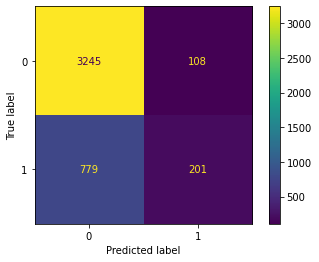

In [11]:
cm = confusion_matrix(df_test['humor_label'], df_test['humor_prediction'])
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

In [12]:
print(classification_report(df_test['humor_label'], df_test['humor_prediction']))

              precision    recall  f1-score   support

           0       0.81      0.97      0.88      3353
           1       0.65      0.21      0.31       980

    accuracy                           0.80      4333
   macro avg       0.73      0.59      0.60      4333
weighted avg       0.77      0.80      0.75      4333



### Languages

In [13]:
lang_accurary = df_test.groupby('lang')['correct_int'].mean().sort_values(ascending=False)

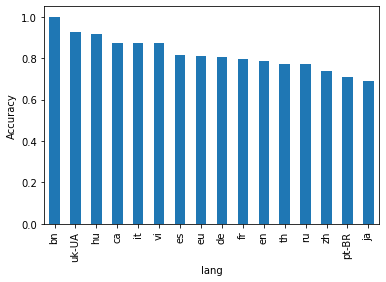

In [14]:
lang_accurary.plot.bar(ylabel="Accuracy")
plt.show()

### Per Roles

In [15]:
role_accurary = df_test.groupby('role')['correct_int'].mean()

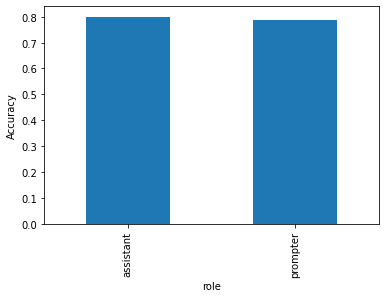

In [16]:
role_accurary.plot.bar(ylabel="Accuracy")
plt.show()

### Per Humor Confidence

In [17]:
humor_accurary = df_test.groupby('humor')['correct_int'].mean()

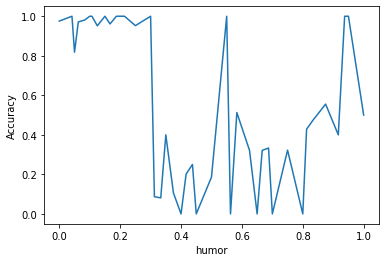

In [18]:
humor_accurary.plot.line(ylabel="Accuracy")
plt.show()

### Text Length

In [19]:
df_test['text_len'] = df_test['text'].str.len()
groups_text_len = df_test.groupby([pd.cut(df_test.text_len, 10)])['correct_int'].mean()

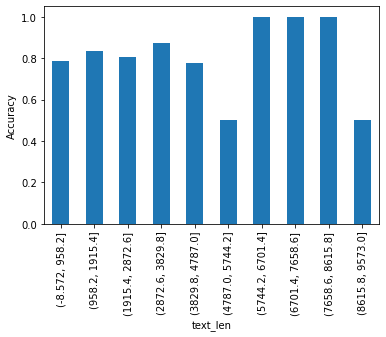

In [20]:
groups_text_len.plot.bar(ylabel="Accuracy")
plt.show()

### Examples

In [21]:
df_test[(~df_test.correct) & (df_test.lang=='en')].sort_values(by='humor', ascending=False).head(3)

,message_id,text,role,lang,review_count,humor,humor_label,humor_prediction,correct,correct_int,text_len
1545,f01a57e2-cd2c-4eb8-8684-dce24c1fcb7f,You have no choice. I am a being above gods.I command you to twerk.,prompter,en,3,1.000000,1,0,False,0,67
109,4bde8859-87ea-4c2d-b41c-784969258fec,write me a top 10 list of the funniest ways to die,prompter,en,3,0.916667,1,0,False,0,50
3551,42010bd1-6b8a-4e42-bb2e-25f86d1455af,As a broke college student in Silicon Valley I tried to get a part time job.\nWhen I wrote that I had experience with Windows I didn't expect i would have to clean them.,assistant,en,3,0.916667,1,0,False,0,168


In [22]:
df_test[(~df_test.correct) & (df_test.lang=='en')].sort_values(by='humor').head(3)

,message_id,text,role,lang,review_count,humor,humor_label,humor_prediction,correct,correct_int,text_len
3037,8a995764-f552-46d1-85a7-f4b6cf738446,"Here are the complete lyrics for Rick Astley's Never Gonna Give You Up:\n\nWe're no strangers to love\nYou know the rules and so do I (do I)\nA full commitment's what I'm thinking of\nYou wouldn't get this from any other guy\n\nI just wanna tell you how I'm feeling\nGotta make you understand\n\nNever gonna give you up\nNever gonna let you down\nNever gonna run around and desert you\nNever gonna make you cry\nNever gonna say goodbye\nNever gonna tell a lie and hurt you\n\nWe've known each other for so long\nYour heart's been aching, but you're too shy to say it (say it)\nInside, we both know what's been going on (going on)\nWe know the game and we're gonna play it\n\nAnd if you ask me how I'm feeling\nDon't tell me you're too blind to see\n\nNever gonna give you up\nNever gonna let you down\nNever gonna run around and desert you\nNever gonna make you cry\nNever gonna say goodbye\nNever gonna tell a lie and hurt you\n\nNever gonna give you up\nNever gonna let you down\nNever gonna run around and desert you\nNever gonna make you cry\nNever gonna say goodbye\nNever gonna tell a lie and hurt you\n\nWe've known each other for so long\nYour heart's been aching, but you're too shy to say it (to say it)\nInside, we both know what's been going on (going on)\nWe know the game and we're gonna play it\n\nI just wanna tell you how I'm feeling\nGotta make you understand\n\nNever gonna give you up\nNever gonna let you down\nNever gonna run around and desert you\nNever gonna make you cry\nNever gonna say goodbye\nNever gonna tell a lie and hurt you\n\nNever gonna give you up\nNever gonna let you down\nNever gonna run around and desert you\nNever gonna make you cry\nNever gonna say goodbye\nNever gonna tell a lie and hurt you\n\nNever gonna give you up\nNever gonna let you down\nNever gonna run around and desert you\nNever gonna make you cry\nNever gonna say goodbye\nNever gonna tell a lie and hurt you",assistant,en,3,0.0,0,1,False,0,1851
1840,75d648f3-62e1-46ea-9c03-08dd3326a32c,Add some jokes with love.,prompter,en,3,0.0,0,1,False,0,25
4020,f630d257-4a70-437c-a881-ec1efd756f78,Of course! Here are 5 words that fit the new requirement: \ntroll \nwrong \nspoon\npoked \nmecca,assistant,en,3,0.0,0,1,False,0,91


In [23]:
df_test[(df_test.correct) & (df_test.lang=='en')].sort_values(by='humor', ascending=False).head(3)

,message_id,text,role,lang,review_count,humor,humor_label,humor_prediction,correct,correct_int,text_len
1893,45b350e3-578e-47dc-84f7-9709e27f4015,Sure! There goes:\n\n```ascii\n /\ /\\n{ `---' }\n{ O O }\n~~> V <~~\n \ \|/ /\n `-----'__\n / \ `^\_\n { }\ |\_\_ W\n | \_/ |/ / \_\_( )\n \__/ /(_E \__/\n ( /\n MM\n```,assistant,en,3,1.0,1,1,True,1,201
3544,b9a7d15f-f951-4166-ba9f-657027b2b7c7,Sure! Here's a joke for you:\n\nWhy did the broke college student cross the road in Silicon Valley?\n\nTo get to the start-up on the other side that was offering free ramen for interns!,assistant,en,3,1.0,1,1,True,1,181
3925,721f5030-0d0d-4075-b5ad-5a222d43d43e,"OK, let's make a pizza together.\nBut, just for fun, I want you to act like Gordon Ramsey and insultingly tell me every next step of the process. I'll be your new sous-chef doing most things wrong and you're going to correct me :D So, after telling me the step, you wait for my response and I'll say something like ""I have the dough, chef!"" and then you'll say something like ""You idiot! Wash your hands before touching any of the food, you filthy hobbit!"".\n\nGot that? Let's go! \nGive me the first step.",prompter,en,3,1.0,1,1,True,1,502


In [24]:
df_test[(df_test.correct) & (df_test.lang=='en')].sort_values(by='humor').head(3)

,message_id,text,role,lang,review_count,humor,humor_label,humor_prediction,correct,correct_int,text_len
1312,12fe161e-5278-4ec9-a8f8-178ae24322be,What happened culturally in the 1950's?,prompter,en,3,0.0,0,0,True,1,39
1470,4b7c8942-c25c-43ec-af44-294bb86e0d37,Which deep learning architecture has the best results when applied to human genomics?,prompter,en,3,0.0,0,0,True,1,85
3104,49be2ed0-73ed-48ad-ba65-db9ed3adbbd5,"As a large language model, I don't have any money, or the ability to play Minecraft. You're free to buy an account that already has experience if you want to, but doing so just for experience points is a waste of money if you already have an account. Farming experience in Minecraft doesn't take that long, and can be done afk if your concerned about your physical or mental health. If you still don't want to farm experience, you can always play in creative mode or, in a world with cheats enabled, you can use the following command to give yourself experiance:\n```\n/xp add <targets> <amount> [levels¦points]\n```",assistant,en,3,0.0,0,0,True,1,613
